## Deep learning for Metal distortion detection

In [3]:
!nvidia-smi 

Wed Jan 19 14:49:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Connect to drive folder to use the dataset (The dataset is publicily available)
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Fault detection'
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Fault detection
 AccVal_acc.png
 app.py
 Checkpoint
'Deep learning for Metal distortion detection.ipynb'
 images
 LossVal_loss.png
 model.png
 my_net.h5
 README.md
 requirements.txt
 static
 templates
'Transfer Learning Inception V3.ipynb'
'Transfer Learning Resnet 50.ipynb'
 uploads


In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.per_process_gpu_memory_fraction = 1
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
# import the libraries as shown below

import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import EfficientNetB7 
from tensorflow.keras.applications import DenseNet201
import numpy as np
from glob import glob


In [7]:
# re-size all the images to this
IMAGE_SIZE = [200, 200]

train_path = '/content/drive/MyDrive/Colab Notebooks/Fault detection/uploads/Database/Train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Fault detection/uploads/Database/Test'


In [8]:
# Choose the pre-trained model

# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
my_net = DenseNet201(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#my_vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#my_mobileNET = MobileNetV3Large(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#my_efficent_Net = EfficientNetB7(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

74850304/74836368 [==============================] - 0s 0us/step


In [9]:
# don't train existing weights
count = 0
for layer in my_net.layers:
    layer.trainable = True
    count += 1
print('Total number of layers: {}'.format(count))
   

Total number of layers: 707


In [14]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Colab Notebooks/Fault detection/uploads/Database/Train/*')
# our layers - you can add more if you want
# x = Flatten()(inception.output)
# x = Flatten()(my_vgg16.output)
# x = Flatten()(my_mobileNET.output)
x = Flatten()(my_net.output)
print(x)


KerasTensor(type_spec=TensorSpec(shape=(None, 69120), dtype=tf.float32, name=None), name='flatten_1/Reshape:0', description="created by layer 'flatten_1'")


In [11]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
# model = Model(inputs=inception.input, outputs=prediction)
# model = Model(inputs=my_vgg16.input, outputs=prediction)
# model = Model(inputs=my_mobileNET.input, outputs=prediction)
model = Model(inputs=my_net.input, outputs=prediction)

In [12]:
#Package to view the model structure 
!pip install visualkeras


     |████████████████████████████████| 795 kB 33.0 MB/s 


In [17]:

# view the structure of the model
# model.summary()
import visualkeras

#visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='model.png').show() # write and show
display(file="model.png")

In [ ]:
# tell the model what cost and optimization method to use

model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizers.Adam(learning_rate=0.001),
  metrics=['accuracy']
)


In [ ]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (200, 200),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


Found 1440 images belonging to 6 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (200, 200),
                                            batch_size = 360,
                                            class_mode = 'categorical')

Found 360 images belonging to 6 classes.


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 
!rm -rf ./Checkpoint/ 
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_model = "Checkpoint/" + datetime.datetime.now().strftime("%Y%m%d-%H")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
models_callback = tf.keras.callbacks.ModelCheckpoint(log_model, verbose=1, save_best_only=True)

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[models_callback])


Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 1.7518 - accuracy: 0.8049
Epoch 00001: val_loss did not improve from 0.20303
45/45 [==============================] - 46s 1s/step - loss: 1.7518 - accuracy: 0.8049 - val_loss: 1.4616 - val_accuracy: 0.6806
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.0475 - accuracy: 0.8618
Epoch 00002: val_loss did not improve from 0.20303
45/45 [==============================] - 46s 1s/step - loss: 1.0475 - accuracy: 0.8618 - val_loss: 1.9656 - val_accuracy: 0.7667
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.8681
Epoch 00003: val_loss did not improve from 0.20303
45/45 [==============================] - 46s 1s/step - loss: 0.6811 - accuracy: 0.8681 - val_loss: 3.3704 - val_accuracy: 0.5639
Epoch 4/10
45/45 [==============================] - ETA: 0s - loss: 0.7188 - accuracy: 0.8444
Epoch 00004: val_loss did not improve from 0.20303
45/45 [==========================

 AccVal_acc.png
 app.py
 Checkpoint
'Deep learning for Metal distortion detection.ipynb'
 images
 LossVal_loss.png
 model.png
 my_net.h5
 README.md
 requirements.txt
 static
 templates
'Transfer Learning Inception V3.ipynb'
'Transfer Learning Resnet 50.ipynb'
 uploads


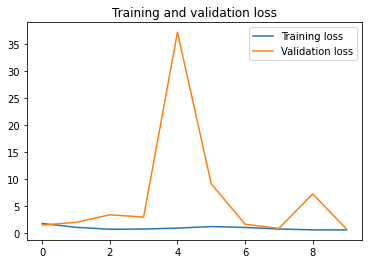

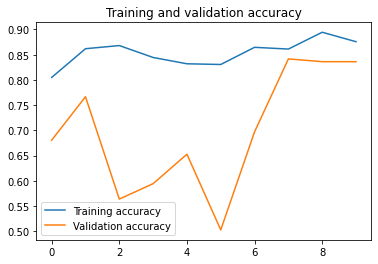

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title
# plot the loss
!ls
plt.plot(r.history['loss'], label='Training loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='Training accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save it as a h5 file
# model.save('model_inception.h5')
# model.save('model_vgg16.h5')
# model.save('model_mobileNet.h5')
# model.save('my_efficent_Net.h5') 
#model_2 = load_model('model_inception.h5')

loaded_model = load_model(log_model)
loaded_model.save('my_net.h5')